In [1]:
import pandas as pd
import DataLoading
import torch
import matplotlib.pyplot as plt
import NN_evaluation
import numpy as np 
import random

In [38]:
sc = "sc01"
period = "2030"
case = "9n"
#folder = f"../Data/{case}_AC_12w_ext_o_dummy_LCOE/"
folder = f"../Data/{case}_AC_fy_ext_o_dummy_LCOE/"
#folder = "../Data/RTS24_AC_12w_ext_o_dummy/"
all_executions = DataLoading.list_executions(folder=folder,per = period,sc=sc)
te_s = 0.3
val_s = 0.4
dfs_in, dfs_out, dfs_inter = DataLoading.load_data_ext_out(folder, all_executions, period, sc, ["PowerFlow"])
dfs_inter_j = DataLoading.join_frames_inter_layer(dfs_inter)
dfs_inter_j = DataLoading.trim_columns_to_common(dfs_inter_j)
# Convert to pytorch tensors
ts_in, ts_out, ts_inter = DataLoading.split_tr_val_te_ext_out(dfs_in, dfs_out, dfs_inter_j, all_executions, te_s, val_s)
d_ft_in, d_ft_out, d_ft_inter,maxs = DataLoading.concat_and_normalize_ext_out(ts_in, ts_out, ts_inter, all_executions)

input_size = dfs_in["Network_Existing_Generation_Full"].shape[1]
inter_size = dfs_inter_j["Network_Existing_Generation_Full"].shape[1]

input_f_sc01_Network_Existing_Generation_Full_2030.csv
24
input_f_sc01_Network_Line_In_Node_1_Node_6_cac1_2030.csv
24
input_f_sc01_Network_Line_In_Node_1_Node_6_cac2_2030.csv
24
input_f_sc01_Network_Line_In_Node_1_Node_6_cac3_2030.csv
24
input_f_sc01_Network_Line_In_Node_2_Node_3_cac1_2030.csv
24
input_f_sc01_Network_Line_In_Node_2_Node_3_cac2_2030.csv
24
input_f_sc01_Network_Line_In_Node_2_Node_3_cac3_2030.csv
24
input_f_sc01_Network_Line_In_Node_2_Node_6_cac1_2030.csv
24
input_f_sc01_Network_Line_In_Node_2_Node_6_cac2_2030.csv
24
input_f_sc01_Network_Line_In_Node_2_Node_6_cac3_2030.csv
24
input_f_sc01_Network_Line_In_Node_3_Node_4_cac1_2030.csv
24
input_f_sc01_Network_Line_In_Node_3_Node_4_cac2_2030.csv
24
input_f_sc01_Network_Line_In_Node_3_Node_4_cac3_2030.csv
24
input_f_sc01_Network_Line_In_Node_3_Node_6_cac1_2030.csv
24
input_f_sc01_Network_Line_In_Node_3_Node_6_cac2_2030.csv
24
input_f_sc01_Network_Line_In_Node_3_Node_6_cac3_2030.csv
24
input_f_sc01_Network_Line_In_Node_4_Node_5

In [39]:
hyperloop_name = "RTS24_AC_12w_dummy_0.3_v0.4_PF_sa_rand_0_40"
hyperloop_name = "3-bus_AC_12w_dummy_0.3_v0.4_PF_LCOE_0_10"
hyperloop_name = "9n_AC_12w_dummy_0.3_v0.4_PF_LCOE_0_37"

df_losses = pd.read_csv(f"ResultsClusterRuns/Loss_results_csv/{hyperloop_name}.csv",index_col=0)
#df_losses = pd.read_csv(f"Loss_results_csv/{hyperloop_name}.csv",index_col=0)
cluster_run =True
f = df_losses.alpha ==0.0

loss_to_sort = "Te_l_mae"

[48, 72, 18, 12, 6]


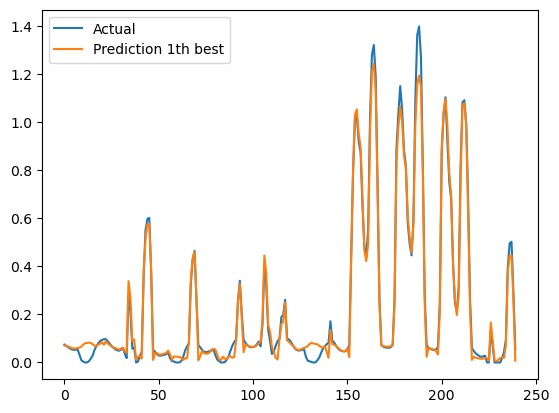

In [48]:
#Visualisation of multiple models in input order
ex = all_executions[0]


#ex_in = torch.nan_to_num(ts_in[data_part][ex]/maxs["in"])
ex_in = torch.nan_to_num(dfs_in[ex].to_numpy()/maxs["in"])
ex_out = dfs_out[ex].sum(axis=1).to_numpy()


s = 24*0
e=s+24*10
plt.plot(ex_out[s:e],label = "Actual")

for xth_best in [1]: 
    row = NN_evaluation.find_xthbest_model_params_from_df(df_losses[f],loss_to_sort,xth_best)
    m = NN_evaluation.create_model_and_load_state_from_row(row,input_size,inter_size,hyperloop_name,cluster_run=cluster_run)
    prediction = m(ex_in.float())[0].detach().numpy()
    plt.plot(prediction[s:e],label = f"Prediction {xth_best}th best")
plt.legend()

[48, 72, 18, 12, 6]
[48, 72, 18, 12, 6]


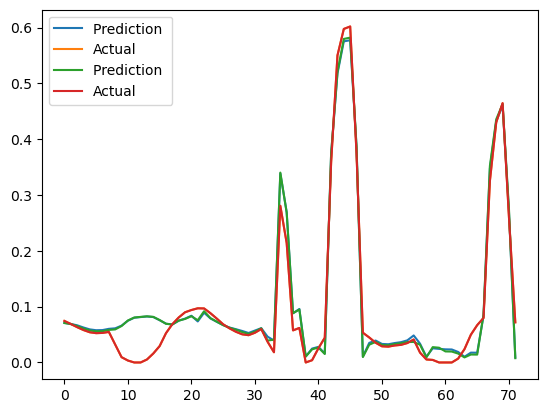

In [6]:
#Visualisation of multiple executions in input order
ex = all_executions[0]


#ex_in = torch.nan_to_num(ts_in[data_part][ex]/maxs["in"])

j = 2

s = 0
e=s+72


for ex_i in [0,32]:
    ex = all_executions[ex_i]
    row = NN_evaluation.find_xthbest_model_params_from_df(df_losses[f],loss_to_sort,xth_best)
    m = NN_evaluation.create_model_and_load_state_from_row(row,input_size,inter_size,hyperloop_name,cluster_run=cluster_run)
    ex_in = torch.nan_to_num(dfs_in[ex].to_numpy()/maxs["in"])
    ex_out = dfs_out[ex].sum(axis=1).to_numpy()
    prediction = m(ex_in.float())[0].detach().numpy()
    plt.plot(prediction[s:e],label = f"Prediction ")
    plt.plot(ex_out[s:e],label = f"Actual")

plt.legend()

[48, 18, 12]


Text(0.5, 1.0, 'Derived line benefits')

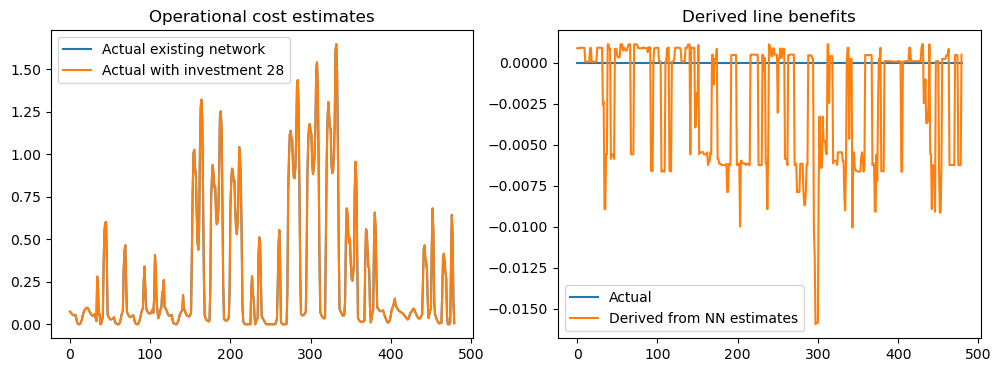

In [37]:
#Visualisation of multiple executions in input order
f = df_losses.alpha ==0.0
loss_to_sort = "Te_l_t_mse"
xth_best = 1
row = NN_evaluation.find_xthbest_model_params_from_df(df_losses[f],loss_to_sort,xth_best)
m = NN_evaluation.create_model_and_load_state_from_row(row,input_size,inter_size,hyperloop_name,cluster_run=cluster_run)

#ex_in = torch.nan_to_num(ts_in[data_part][ex]/maxs["in"])

l_idx = 28
ex = all_executions[l_idx]
negf = all_executions[0]


ex_in_e = torch.nan_to_num(dfs_in[ex].to_numpy()/maxs["in"])
ex_in_negf = torch.nan_to_num(dfs_in[negf].to_numpy()/maxs["in"])

prediction_e = m(ex_in_e.float())[0].detach().numpy()
prediction_negf = m(ex_in_negf.float())[0].detach().numpy()

actual_e = NN_evaluation.get_actual_from_dfs_out(ex,dfs_out)
actual_negf = NN_evaluation.get_actual_from_dfs_out(negf,dfs_out)

lb_est = prediction_negf- prediction_e
lb_actual = NN_evaluation.calculate_lb_from_dfs_out(dfs_out,ex)



#s= random.randint(0,len(actual_e))
s=0
e = s+480

fig, axs = plt.subplots(1,2,figsize = (12,4))

axs[0].plot(actual_negf[s:e],label = "Actual existing network")
#axs[0].plot(prediction_e[s:e],label = "NN Estimate existing network")
axs[0].plot(actual_e[s:e],label = f"Actual with investment {l_idx}")
#axs[0].plot(prediction_negf[s:e],label = f"NN Estimate with investment {l_idx} ")

axs[0].legend()
axs[0].set_title("Operational cost estimates")


axs[1].plot(lb_actual[s:e],label = "Actual")
axs[1].plot(lb_est[s:e],label = "Derived from NN estimates")

axs[1].legend()
axs[1].set_title(f"Derived line benefits")

#axs[2].hist(lb_actual/actual_negf,bins= 100)



In [33]:
sum(actual_negf)

312.12915148108857